In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Imports

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
import pickle
import numpy as np
from pathlib import Path

In [3]:
path = Path('../../../../data/midas data')

In [4]:
path.ls()

[PosixPath('../../../../data/midas data/test_image.pkl'),
 PosixPath('../../../../data/midas data/train_image.pkl'),
 PosixPath('../../../../data/midas data/train'),
 PosixPath('../../../../data/midas data/.ipynb_checkpoints'),
 PosixPath('../../../../data/midas data/models'),
 PosixPath('../../../../data/midas data/train_label.pkl')]

# Loading the provided Pickle Data

In [5]:
pickle_in = open(path/"train_image.pkl","rb")
train_image = pickle.load(pickle_in)
pickle_in = open(path/"test_image.pkl","rb")
test_image = pickle.load(pickle_in)
pickle_in = open(path/"train_label.pkl","rb")
train_label = pickle.load(pickle_in)

In [26]:
classes = {}
for i in range(0,len(train_label)):
    if train_label[i] not in classes.keys():
        classes[train_label[i]] = i

print(classes)

{0: 0, 2: 2000, 3: 4000, 6: 6000}


#### The above analysis confirms that the problem is a classical classification problem with 4 classes and can be solved using a pretrained CNN

# Preparing Data for Creating Data Bunch

### Data Bunch can be created using data and labels in a variety of ways few of which are :-
#### 1) Labels provided as csv
#### 2) Folders named as the corresponding class name
#### 3) Labels provided as DataFrame

#### Here I choose to follow the most convinient method where images are saved in a folder named after their corresponding class labels

In [42]:
from scipy.misc import imsave

In [53]:
for i in range(0,len(train_image)):
    img = (np.reshape(train_image[i],(28,28)))
    plt.imsave(path/f'train/{train_label[i]}/{i}.jpg',img)

# Preparing DataBunch object 
### The DataBunch is loaded into the CNN model during initialization and contains the training and test data loaders 
### Parameters passed are path of training data and test data, resizing value and augmentations to applied
#### Augmentations are applied to create multiple images from a single image which helps the model to generalize better and also increases the size of training data. get_transforms is a unction that returns the augmented training data on the basis of parameters passed to the function

In [6]:
data = ImageDataBunch.from_folder(path, train="path/train",test = "test", valid_pct=0.2,
        ds_tfms=get_transforms(max_zoom=0.5, max_warp=0.05, max_rotate=0.05, max_lighting=0.2), size=229, num_workers=4).normalize(imagenet_stats)

In [89]:
data.classes

['0', '2', '3', '6']

### An overview of the data that is contained in the DataBunch and will be used for training

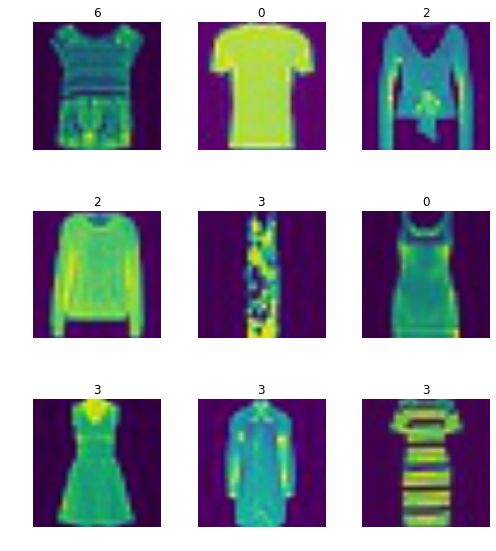

In [7]:
data.show_batch(rows=3, figsize=(7,8))

In [7]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [8]:
import gc
gc.collect()

0

In [98]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,0.795613,0.594412,0.231875
2,0.580281,0.478837,0.198125
3,0.474849,0.440289,0.178750
4,0.408087,0.427656,0.173125


In [99]:
learn.save('model1')

In [9]:
learn = learn.load('model1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


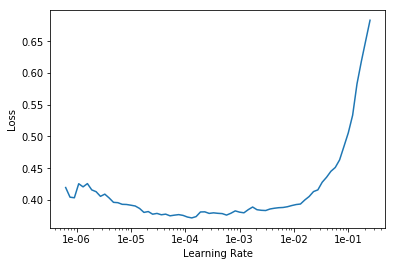

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(10,1e-04)

epoch,train_loss,valid_loss,error_rate
1,0.405519,0.312472,0.123750
2,0.404270,0.309963,0.116875
3,0.395848,0.308292,0.122500
4,0.375760,0.303990,0.114375
5,0.350339,0.302149,0.113125
6,0.350328,0.299229,0.116875
7,0.333823,0.297533,0.115000
8,0.330459,0.294514,0.115000
9,0.325437,0.297069,0.115000
10,0.342698,0.294795,0.115000


In [12]:
learn.save('model-2')

In [10]:
learn = learn.load('model-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


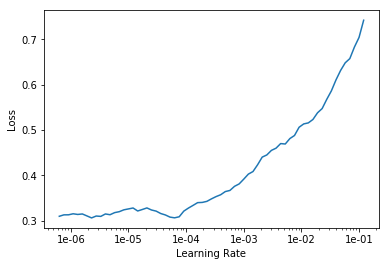

In [11]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [12]:
lr = 2e-05
lrs = [lr/100,lr/10,lr]

In [13]:
learn.fit_one_cycle(20,lrs)

epoch,train_loss,valid_loss,error_rate
1,0.325670,0.256947,0.095000
2,0.328570,0.257084,0.091250
3,0.332154,0.256913,0.098750
4,0.323945,0.256751,0.095625
5,0.316000,0.256355,0.095000
6,0.305751,0.255513,0.095625
7,0.292926,0.255326,0.098750
8,0.287048,0.254250,0.098750
9,0.279818,0.256677,0.098125
10,0.277246,0.254325,0.096875


In [14]:
learn.save('model-unfreeze-1')

In [15]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


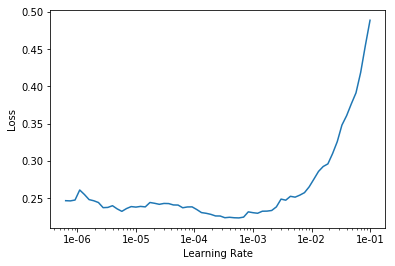

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(20,2e-04)

epoch,train_loss,valid_loss,error_rate
1,0.231184,0.251359,0.095000
2,0.232682,0.252725,0.101875
3,0.222069,0.255598,0.101875
4,0.222472,0.257624,0.100000
5,0.218740,0.258378,0.098125
6,0.206855,0.268607,0.108125
7,0.199418,0.269555,0.107500
8,0.195913,0.266118,0.110000
9,0.178057,0.276302,0.107500
10,0.169724,0.277773,0.108125


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda

KeyboardInterrupt: 

#### As clearly visible that during the later epochs the model started to overfit(Training loss was decreasing while validation loss was constantly increasing ) therefore, we should try using different augmentations and bigger image size for further training

In [22]:
data = ImageDataBunch.from_folder(path, train="path/train",test = "test", valid_pct=0.2,
        ds_tfms=get_transforms(max_zoom=0.5, max_warp=0.05, max_rotate=0.05, max_lighting=0.2),bs=24, size=299, num_workers=4).normalize(imagenet_stats)
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


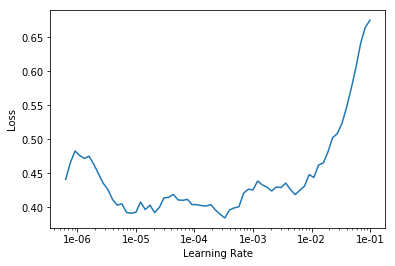

In [23]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(20,1e-04)

epoch,train_loss,valid_loss,error_rate
1,0.388718,0.232903,0.091875
2,0.367789,0.221369,0.089375
3,0.319253,0.215307,0.086250
4,0.322679,0.199443,0.078750
5,0.270035,0.192897,0.070625
6,0.266031,0.190057,0.073750
7,0.252755,0.195772,0.070000
8,0.230602,0.186705,0.062500
9,0.249620,0.191849,0.070625
10,0.221522,0.194334,0.074375


In [25]:
learn.save('model-1-299')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


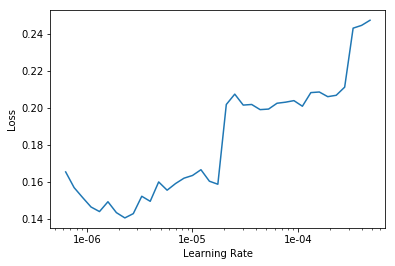

In [26]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [27]:
lr = 6e-07
lrs = [lr/100,lr/10,lr]

In [28]:
learn.fit_one_cycle(10,lrs)

epoch,train_loss,valid_loss,error_rate
1,0.174123,0.188250,0.068125
2,0.172249,0.190885,0.073125
3,0.185342,0.187167,0.067500
4,0.177073,0.186838,0.072500
5,0.186362,0.189909,0.067500
6,0.176530,0.190518,0.073750
7,0.193072,0.195787,0.075000
8,0.176687,0.193821,0.076250
9,0.189637,0.185954,0.073125
10,0.168117,0.195526,0.075625


In [29]:
learn.save('model-299-unfreezed-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


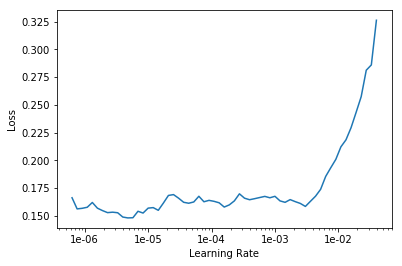

In [31]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(10,5e-06)

epoch,train_loss,valid_loss,error_rate
1,0.175700,0.192942,0.073125
2,0.157627,0.190403,0.071875
3,0.170977,0.194167,0.075000
4,0.173627,0.197601,0.073750
5,0.176559,0.185791,0.069375
6,0.183332,0.188042,0.072500
7,0.179624,0.188948,0.069375
8,0.186391,0.190371,0.068750
9,0.176624,0.187633,0.066875
10,0.193533,0.191989,0.073750


In [33]:
learn.save('model-fuf-299')

In [9]:
learn = learn.load('model-fuf-299')

### Summary provides an overview of the total number of layers in our network and the shape and type of each layer 

In [10]:
learn.summary()

'======================================================================\nLayer (type)         Output Shape         Param #    Trainable \n======================================================================\nConv2d               [64, 64, 115, 115]   9,408      False     \n______________________________________________________________________\nBatchNorm2d          [64, 64, 115, 115]   128        True      \n______________________________________________________________________\nReLU                 [64, 64, 115, 115]   0          False     \n______________________________________________________________________\nMaxPool2d            [64, 64, 58, 58]     0          False     \n______________________________________________________________________\nConv2d               [64, 64, 58, 58]     4,096      False     \n______________________________________________________________________\nBatchNorm2d          [64, 64, 58, 58]     128        True      \n________________________________________

In [ ]:
for i in range(0,len(test_image)):
    img = (np.reshape(test_image[i],(28,28)))
    plt.imsave(path/f'test/{i}.jpg',img)